In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Rescaling, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data.experimental import cardinality
from tensorflow import cast
from tensorflow import float32
from tensorflow import argmax

2024-06-24 20:48:31.886807: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 20:48:32.239228: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 20:48:32.239276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 20:48:32.304137: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-24 20:48:32.439257: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 20:48:32.441160: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
# Create the dataset
dataset = image_dataset_from_directory(
    "./raw_data/images/",
    labels='inferred',  # Automatically infer labels
    validation_split=0.2,
    subset="training",
    label_mode='categorical',  # Labels are returned as one-hot encoded vectors
    batch_size=64,  # Number of images in each batch
    image_size=(128, 128),  # Resize images to 256x256
    shuffle=True,  # Shuffle the data
    seed=42  # Set seed for reproducibility
)

# Create the dataset
validation_dataset = image_dataset_from_directory(
    "./raw_data/images/",
    labels='inferred',  # Automatically infer labels
    validation_split=0.2,
    subset="validation",
    label_mode='categorical',  # Labels are returned as one-hot encoded vectors
    batch_size=64,  # Number of images in each batch
    image_size=(128, 128),  # Resize images to 256x256
    shuffle=True,  # Shuffle the data
    seed=42  # Set seed for reproducibility
)

Found 15000 files belonging to 30 classes.
Using 12000 files for training.
Found 15000 files belonging to 30 classes.
Using 3000 files for validation.


In [3]:
# Calculate the number of batches
val_batches = cardinality(validation_dataset)
test_batches = val_batches // 2
val_batches = val_batches - test_batches

# Split the validation dataset into validation and test sets
test_dataset = validation_dataset.take(test_batches)
validation_dataset = validation_dataset.skip(test_batches)

In [4]:
print(f'Training set size: {cardinality(dataset).numpy()} batches')
print(f'Validation set size: {cardinality(validation_dataset).numpy()} batches')
print(f'Test set size: {cardinality(test_dataset).numpy()} batches')

Training set size: 188 batches
Validation set size: 24 batches
Test set size: 23 batches


In [5]:
dataset.class_names

['aerosol_cans',
 'aluminum_food_cans',
 'aluminum_soda_cans',
 'cardboard_boxes',
 'cardboard_packaging',
 'clothing',
 'coffee_grounds',
 'disposable_plastic_cutlery',
 'eggshells',
 'food_waste',
 'glass_beverage_bottles',
 'glass_cosmetic_containers',
 'glass_food_jars',
 'magazines',
 'newspaper',
 'office_paper',
 'paper_cups',
 'plastic_cup_lids',
 'plastic_detergent_bottles',
 'plastic_food_containers',
 'plastic_shopping_bags',
 'plastic_soda_bottles',
 'plastic_straws',
 'plastic_trash_bags',
 'plastic_water_bottles',
 'shoes',
 'steel_food_cans',
 'styrofoam_cups',
 'styrofoam_food_containers',
 'tea_bags']

In [6]:
class_names = dataset.class_names

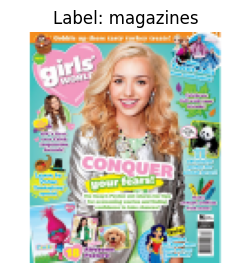

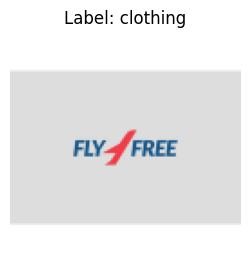

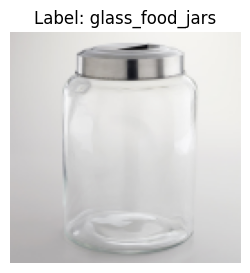

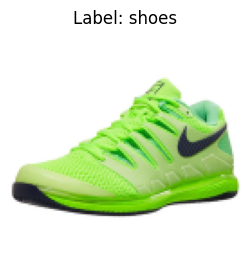

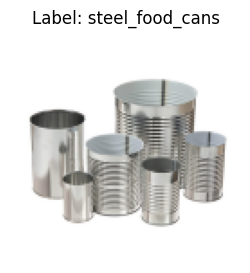

In [7]:
# Display example images with labels
for images, labels in dataset.take(1):
    # Convert the first 5 images to numpy arrays and display them
    for i in range(5):
        plt.figure(figsize=(3, 3))
        plt.imshow(images[i].numpy().astype("uint8"))
        # Extract label index from one-hot encoded vector
        label_index = argmax(labels[i]).numpy()
        plt.title(f"Label: {class_names[label_index]}")
        plt.axis("off")
        plt.show()

In [8]:
def normalize(image, label):
    image = cast(image, float32) / 255.0
    return image, label

In [9]:
dataset = dataset.map(normalize)
validation_dataset = validation_dataset.map(normalize)
test_dataset = test_dataset.map(normalize)

In [10]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD

def initialize_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.3))
    model.add(Dense(30, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [11]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 64)        36928     
                                                        

In [12]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.data import AUTOTUNE

#datagen = ImageDataGenerator(
#    featurewise_center = False,
#    featurewise_std_normalization = False,
#    rotation_range = 10,
#    width_shift_range = 0.1,
#    height_shift_range = 0.1,
#    horizontal_flip = True,
#    zoom_range = (0.8, 1.2),
#    )

# Configure dataset for performance
#AUTOTUNE = AUTOTUNE
#train_dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Convert train_dataset to NumPy array and fit the datagen
#train_images = []
#train_labels = []
#for images, labels in train_dataset:
#    train_images.append(images.numpy())
#    train_labels.append(labels.numpy())

#train_images = np.concatenate(train_images)
#train_labels = np.concatenate(train_labels)

In [13]:
#train_flow = datagen.flow(train_images, train_labels, batch_size = 64)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model_small = initialize_model()

es = EarlyStopping(patience = 10, verbose = 2, restore_best_weights=True)

# Train the model with EarlyStopping
history_small = model_small.fit(
    dataset,
    validation_data=validation_dataset,
    callbacks=[es],
    epochs=200,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

Epoch 1/200


2024-06-24 20:48:42.540583: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-06-24 20:48:42.737731: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-06-24 20:48:44.513664: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.
2024-06-24 20:48:44.675874: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


  1/188 [..............................] - ETA: 11:59 - loss: 5.3561 - accuracy: 0.0781

2024-06-24 20:48:45.611937: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 134217728 exceeds 10% of free system memory.


 91/188 [=============>................] - ETA: 4:09 - loss: 3.4439 - accuracy: 0.0326

In [ ]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [ ]:
plot_history(history_small)
plt.show()

In [ ]:
res = model_small.evaluate(test_dataset, verbose = 0)

print(f'The accuracy is {res[1]*100:.1f}% compared to a chance level of {1./len(labels)*100}%')

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
 # plot loss
 plt.subplot(211)
 plt.title('Cross Entropy Loss')
 plt.plot(history.history['loss'], color='blue', label='train')
 plt.plot(history.history['val_loss'], color='orange', label='test')
 # plot accuracy
 plt.subplot(212)
 plt.title('Classification Accuracy')
 plt.plot(history.history['accuracy'], color='blue', label='train')
 plt.plot(history.history['val_accuracy'], color='orange', label='test')
 # save plot to file
 #filename = sys.argv[0].split('/')[-1]
 #plt.savefig(filename + '_plot.png')
 plt.close()

In [ ]:
summarize_diagnostics(history_small)

In [ ]:
# serialize model to JSON
model_json = model_small.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
model_small.save("model.keras")

In [ ]:
from tensorflow.keras.regularizers import l2

# define cnn model
def define_model_weightdecay():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001), input_shape=(128, 128, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', kernel_regularizer=l2(0.001)))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.001)))
 model.add(Dense(30, activation='softmax'))
 # compile model
 opt = SGD(learning_rate=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

In [ ]:
model_weight_decay = define_model_weightdecay()

In [ ]:
# Train the model with EarlyStopping
history_weight_decay = model_weight_decay.fit(
    dataset,
    validation_data=validation_dataset,
    callbacks=[es],
    epochs=200,
    batch_size=64  # Note: batch_size is already set in image_dataset_from_directory; it's usually best to keep it consistent
)

In [ ]:
plot_history(history_weight_decay)
plt.show()

In [ ]:
summarize_diagnostics(history_weight_decay)

In [ ]:
# define cnn model
def define_baseline_model():
 model = Sequential()
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(128, 128, 3)))
 model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Flatten())
 model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
 model.add(Dense(30, activation='softmax'))
 # compile model
 opt = SGD(learning_rate=0.001, momentum=0.9)
 model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
 return model

In [ ]:
baseline_model = define_baseline_model()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.data import AUTOTUNE

# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

# Convert train_dataset to NumPy array and fit the datagen
train_images = []
train_labels = []
for images, labels in dataset:
    train_images.append(images.numpy())
    train_labels.append(labels.numpy())

train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)

train_flow = datagen.flow(train_images, train_labels, batch_size = 64)

In [ ]:
# fit model
steps = int(train_images.shape[0] / 64)
history = baseline_model.fit(train_flow, steps_per_epoch=steps, epochs=100, callbacks=[es], validation_data=validation_dataset)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 10, verbose = 2, restore_best_weights=True)

# fit model
steps = int(train_images.shape[0] / 64)
mixed_model = initialize_model()
history = mixed_model.fit(train_flow, steps_per_epoch=steps, epochs=300, callbacks=[es], validation_data=validation_dataset)